In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

### LOAD FEATURE VECTORS

        75: FEATURE vectores for traget person
        24: FEATURE vectores for adversarial person

In [44]:
target_128= np.load('../Target_x_128.npy')
adv_128= np.load('../adv_x_128.npy')

In [3]:
target_128.shape, adv_128.shape

((75, 128), (24, 128))

In [4]:
# 128 -> 2 dim pca 
def convert_pca(x, ret= False):
    pca= PCA(n_components=2)
    x= pca.fit_transform(x)
    if ret:
        return pca, x
    return x

mix_128= np.concatenate([adv_128, target_128])  #0->23(adv_x_128), 24->36(Target_x_128)
pca, mix_2= convert_pca(mix_128, ret= True)

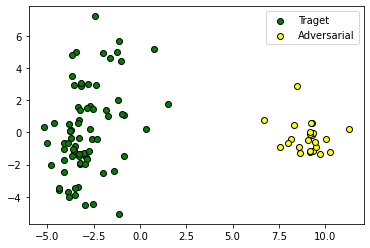

In [5]:
plt.scatter(mix_2[24:, 0], mix_2[24:, 1], c='green', edgecolors='k', label='Traget')
plt.scatter(mix_2[:24, 0], mix_2[:24, 1], c='yellow',edgecolors='k', label='Adversarial')
plt.legend()
plt.show()

### Let's analyse feature distribution

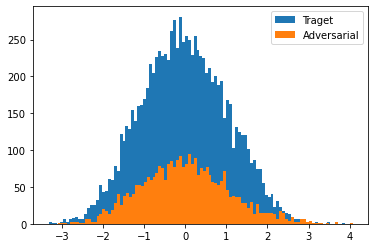

In [6]:
# SACLE [-3 ~ 4]
plt.hist(target_128.flatten(), 100, label='Traget')
plt.hist(adv_128.flatten(), 100, label='Adversarial')
plt.legend()
plt.show()

In [7]:
target_128.max(), target_128.min()

(3.8783252, -3.338596)

In [8]:
adv_128.max(), adv_128.min()

(4.0825906, -3.1021576)

### Initially, the original feature vector fv is multiplied by a large constant, say c = 100 due to its low dynamic range

In [9]:
c= 100
target_128 *= c
adv_128 *= c

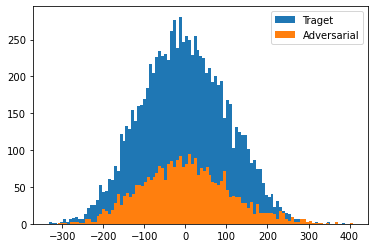

In [10]:
# SACLE [-300 ~ 400]
plt.hist(target_128.flatten(), 100, label='Traget')
plt.hist(adv_128.flatten(), 100, label='Adversarial')
plt.legend()
plt.show()

### To increase the entropy of the template, fv is salted by ORing it with a random grid RG as fs = fv + RG.

    The random grid RG is user-specific and has the same dimensions as that of fv. RG is generated by assigning random integral values with equal probability in the desired range, e.g., [1 to 255].
    
    Seed for Target: 6
    Seed for Adversarial: 11

In [11]:
seed_tar= 6
seed_adv= 11

In [12]:
np.random.seed(seed_tar)
target_128+= np.random.randint(1, 256, size= target_128.shape)

In [13]:
np.random.seed(seed_adv)
adv_128+= np.random.randint(1, 256, size= adv_128.shape)

### Now salted vector is divided into two equal parts
f X =f s(1 : N
/2) and f Y = f s(N
/2 + 1 : N
). Feature
point F Pj is defined as (x j = f X(j), y j = f Y (j)) for
j = 1..N
/2.

In [14]:
def slat_2dim(X):
    samples, features= X.shape
    X_out= np.zeros((samples,features//2, 2))
    for i, x in enumerate(X):
        X_out[i,:, 0]= x[:features//2]
        X_out[i,:, 1]= x[features//2:]
    return X_out

In [15]:
adv_128_salt= slat_2dim(adv_128)
tar_128_salt= slat_2dim(target_128)
tar_128_salt.shape, adv_128_salt.shape

((75, 64, 2), (24, 64, 2))

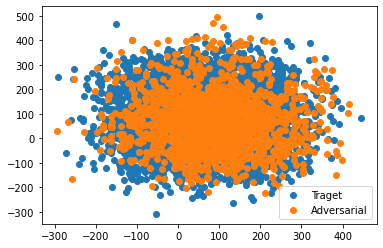

In [16]:
plt.scatter(tar_128_salt[:, :, 0], tar_128_salt[:, :, 1], label='Traget')
plt.scatter(adv_128_salt[:, :, 0], adv_128_salt[:, :, 1], label='Adversarial')
plt.legend()
plt.show()

###  A user-specific key K of dimension 1 × N is generated, which has randomly distributed non-integral values in the range [−100, 100]. 
The key K is also divided into
two equal parts K0 and K1 to define mapping for the random
point RPj , (x j = K0(j), y j = K1(j))

In [17]:
np.random.seed(seed_adv)
adv_k= np.random.randint(-100, 101, size= (1, 128))
print(adv_k.shape)

np.random.seed(seed_tar)
tar_k= np.random.randint(-100, 101, size= (1, 128))
print(tar_k.shape)

(1, 128)
(1, 128)


In [18]:
adv_k= slat_2dim(adv_k)
print(adv_k.shape)

tar_k= slat_2dim(tar_k)
print(tar_k.shape)

(1, 64, 2)
(1, 64, 2)


In [19]:
tar_128_salt.shape, tar_k.shape

((75, 64, 2), (1, 64, 2))

In [20]:
dist =(tar_128_salt- tar_k)**2
dist.shape

(75, 64, 2)

In [21]:
dist= np.sqrt(np.sum(dist, 2))
dist.shape

(75, 64)

In [22]:
def calculate_dist(X, K):
    dist =(X- K)**2
    dist= np.sqrt(np.sum(dist, 2))
    return dist

In [23]:
tar_d= calculate_dist(tar_128_salt, tar_k)
adv_d= calculate_dist(adv_128_salt, adv_k)
tar_d.shape, adv_d.shape

((75, 64), (24, 64))

In [24]:
mix_128= np.concatenate([adv_d, tar_d])  #0->23(adv_x_128), 24->36(Target_x_128)
pca, mix_2_v1= convert_pca(mix_128, ret= True)

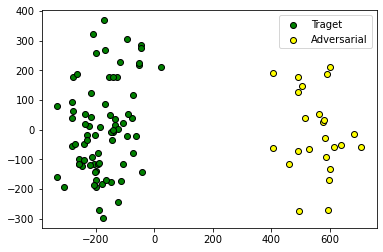

In [25]:
plt.scatter(mix_2_v1[24:, 0], mix_2_v1[24:, 1], c='green', edgecolors='k', label='Traget')
plt.scatter(mix_2_v1[:24, 0], mix_2_v1[:24, 1], c='yellow',edgecolors='k', label='Adversarial')
plt.legend()
plt.show()

### The computation of random distance is a linear operation. 

In order to provide noninvertibility, median filtering is applied on distance vector D
to generate transformed feature vector T f , where the intensity
values are shuffled in p ×1 neighborhood. T f is stored as the
final transformed template.


#### P=8 without seeded shuffling
NOTE:

Token Seed for Target: 6

Seed for Adversarial: 11

In [26]:
def shuffle(X_vec, p=4, seed= 0, with_seed= True):
    for X in X_vec:
        j= 64+p
        for i in np.arange(p, j, p):
            x= X[(i-p):i]
            if with_seed:
                np.random.seed(seed)
            np.random.shuffle(x[:8])
    return X_vec
        

In [27]:
tar_d_shuffled= shuffle(tar_d.copy(),p=8, seed= seed_tar, with_seed= False)
adv_d_shuffled= shuffle(adv_d.copy(),p=8, seed= seed_adv, with_seed= False)

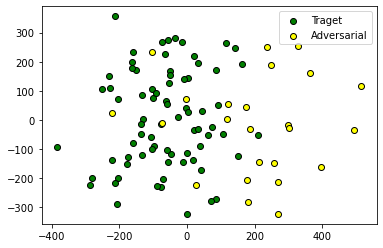

In [28]:
mix_128= np.concatenate([adv_d_shuffled, tar_d_shuffled])  #0->23(adv_x_128), 24->36(Target_x_128)
pca, mix_2_v2= convert_pca(mix_128, ret= True)

plt.scatter(mix_2_v2[24:, 0], mix_2_v2[24:, 1], c='green', edgecolors='k', label='Traget')
plt.scatter(mix_2_v2[:24, 0], mix_2_v2[:24, 1], c='yellow',edgecolors='k', label='Adversarial')
plt.legend()
plt.show()

#### P=4 without seeded shuffling

In [29]:
tar_d_shuffled= shuffle(tar_d.copy(),p=4, seed= seed_tar, with_seed= False)
adv_d_shuffled= shuffle(adv_d.copy(),p=4, seed= seed_adv, with_seed= False)

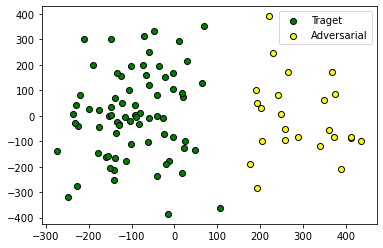

In [30]:
mix_128= np.concatenate([adv_d_shuffled, tar_d_shuffled])  #0->23(adv_x_128), 24->36(Target_x_128)
pca, mix_2_v2= convert_pca(mix_128, ret= True)

plt.scatter(mix_2_v2[24:, 0], mix_2_v2[24:, 1], c='green', edgecolors='k', label='Traget')
plt.scatter(mix_2_v2[:24, 0], mix_2_v2[:24, 1], c='yellow',edgecolors='k', label='Adversarial')
plt.legend()
plt.show()

#### P=8 with seeded shuffling

In [31]:
tar_d_shuffled= shuffle(tar_d.copy(),p=8, seed= seed_tar, with_seed= True)
adv_d_shuffled= shuffle(adv_d.copy(),p=8, seed= seed_adv, with_seed= True)

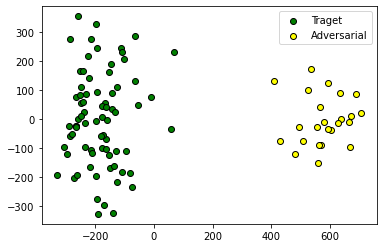

In [32]:
mix_128= np.concatenate([adv_d_shuffled, tar_d_shuffled])  #0->23(adv_x_128), 24->36(Target_x_128)
pca, mix_2_v2= convert_pca(mix_128, ret= True)

plt.scatter(mix_2_v2[24:, 0], mix_2_v2[24:, 1], c='green', edgecolors='k', label='Traget')
plt.scatter(mix_2_v2[:24, 0], mix_2_v2[:24, 1], c='yellow',edgecolors='k', label='Adversarial')
plt.legend()
plt.show()

#### P=4 with seeded shuffling

In [33]:
tar_d_shuffled= shuffle(tar_d.copy(),p=4, seed= seed_tar, with_seed= True)
adv_d_shuffled= shuffle(adv_d.copy(),p=4, seed= seed_adv, with_seed= True)

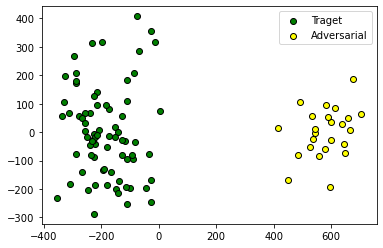

In [34]:
mix_128= np.concatenate([adv_d_shuffled, tar_d_shuffled])  #0->23(adv_x_128), 24->36(Target_x_128)
pca, mix_2_v2= convert_pca(mix_128, ret= True)

plt.scatter(mix_2_v2[24:, 0], mix_2_v2[24:, 1], c='green', edgecolors='k', label='Traget')
plt.scatter(mix_2_v2[:24, 0], mix_2_v2[:24, 1], c='yellow',edgecolors='k', label='Adversarial')
plt.legend()
plt.show()

In [35]:
tar_d_shuffled.shape, adv_d_shuffled.shape

((75, 64), (24, 64))

## MAIN FUNCTIONs

In [42]:
def salt_2dim(X):
    samples, features= X.shape
    X_out= np.zeros((samples,features//2, 2))
    for i, x in enumerate(X):
        X_out[i,:, 0]= x[:features//2]
        X_out[i,:, 1]= x[features//2:]
    return X_out

def shuffle(X_vec, p=4, seed= 0, with_seed= True):
    for X in X_vec:
        j= 64+p
        for i in np.arange(p, j, p):
            x= X[(i-p):i]
            if with_seed:
                np.random.seed(seed)
            np.random.shuffle(x[:8])
    return X_vec


In [43]:
def get_RDM(Fv, token=None, c=100):
    '''
    INPUT---
    Fv.shape: (None, feature)
    token: Uses token key
    PROCESS---
    1. Feature vector(Fv) multiplied by a large constant, say c = 100 due to its low dynamic range.
    2. To increase the entropy of the template, fv is salted by ORing it with a random grid RG as fs = fv + RG.
    3. Fv is divided into two equal parts.
    4. A user-specific key (K) of dimension 1 × N is generated, 
    which has randomly distributed non-integral values in the range [−100, 100].
    5. Computation of distance via random feature vectors.
    6. In order to provide noninvertibility, median filtering is applied on distance vector D
    to generate transformed feature vector T f , where the intensity
    values are shuffled in p ×1 neighborhood. T f is stored as the
    final transformed template.
    OUTPUT---
    Out.shape: (None, feature//2)
    '''
    #1
    Fv*= c
    #2
    np.random.seed(token)
    Fv+= np.random.randint(1, 256, size= Fv.shape)
    #3
    Fv= salt_2dim(Fv)
    #4
    np.random.seed(token)
    K= np.random.randint(-100, 101, size= (1, Fv.shape[-1]))
    #5
    dist =(Fv- K)**2
    dist= np.sqrt(np.sum(dist, 2))
    #6
    Tf= shuffle(dist.copy(), p=4, seed= token, with_seed= True)
    return Tf